<a href="https://colab.research.google.com/github/venki666/CpE477/blob/main/ipy_nbooks/Intro_to_TinyML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

create a neural network that is capable of predicting the output of the sine function. We will then convert this model to a TensorFlow Lite (TFLite) model.

**Model Description**

We are going to create a 3-layer, fully connected neural network that predicts the output of the sine function. As such, we are using it as a regression model. 

The idea is to train a model that accepts values between 0 and 2π and then outputs a value between -1 and 1. If we label the input value as x and the output as y, then the model should be able to predict y = sin(x).



In [1]:
%tensorflow_version 2.x


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from tensorflow.keras import layers
     

Printing version of libraries

In [3]:
# Print versions
!python --version
print('Numpy ' + np.__version__)
print('TensorFlow ' + tf.__version__)
print('Keras ' + tf.keras.__version__)

Python 3.9.16
Numpy 1.22.4
TensorFlow 2.11.0
Keras 2.11.0


generate a random sampling of x values to be used to train our model:

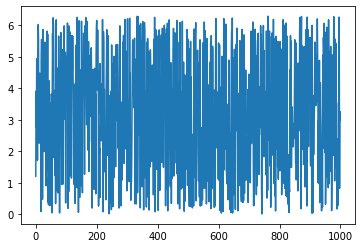

In [14]:
# Settings
nsamples = 1000     # Number of samples to use as a dataset
val_ratio = 0.2     # Percentage of samples that should be held for validation set
test_ratio = 0.2    # Percentage of samples that should be held for test set
tflite_model_name = 'sine_model'  # Will be given .tflite suffix
c_model_name = 'sine_model'       # Will be given .h suffix
# Generate some random samples
np.random.seed(1234)
x_values = np.random.uniform(low=0, high=(2 * math.pi), size=nsamples)
plt.plot(x_values)

calculate sin(x) for each sample and add a little bit of random, Gaussian noise to the output. This helps us ensure the model is an estimation and not a precise representation of a sinewave.

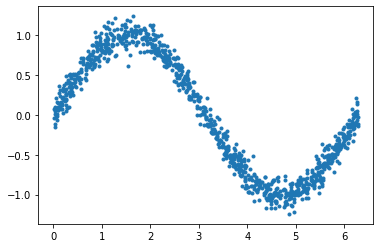

In [15]:
# Create a noisy sinewave with these values
y_values = np.sin(x_values) + (0.1 * np.random.randn(x_values.shape[0]))
plt.plot(x_values, y_values, '.')

split the data up into training, validation, and test sets. It’s usually a good idea to view (or plot) your input data and labels, if possible. Because input and output are only one value here (as opposed to a many-dimensional array), we can visualize the relationship between inputs and outputs more easily:

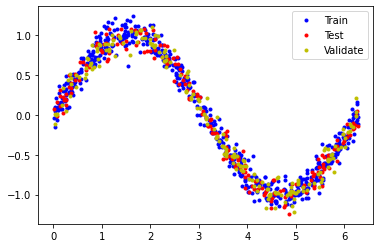

In [16]:
# Plit the dataset into training, validation, and test sets
val_split = int(val_ratio * nsamples)
test_split = int(val_split + (test_ratio * nsamples))
x_val, x_test, x_train = np.split(x_values, [val_split, test_split])
y_val, y_test, y_train = np.split(y_values, [val_split, test_split])

# Check that our splits add up correctly
assert(x_train.size + x_val.size + x_test.size) == nsamples

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_val, y_val, 'y.', label="Validate")
plt.legend()
plt.show()

create the model. We’ll use a 3-layer, fully-connected (dense) neural network.  compile it with our set optimizers and loss functions, followed by the actual training procedure:

In [17]:
# Create a model
model = tf.keras.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(1,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1))
     
# View model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                32        
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


 compile it with our set optimizers and loss functions, followed by the actual training procedure:

In [18]:
# Add optimizer, loss function, and metrics to model and compile it
model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])
     

# Train model
history = model.fit(x_train,
                    y_train,
                    epochs=500,
                    batch_size=100,
                    validation_data=(x_val, y_val))

Epoch 1/500
6/6 [==============================] - 1s 27ms/step - loss: 0.9761 - mae: 0.9761 - val_loss: 0.9517 - val_mae: 0.9517
Epoch 2/500
6/6 [==============================] - 0s 6ms/step - loss: 0.8750 - mae: 0.8750 - val_loss: 0.8659 - val_mae: 0.8659
Epoch 3/500
6/6 [==============================] - 0s 6ms/step - loss: 0.8143 - mae: 0.8143 - val_loss: 0.8006 - val_mae: 0.8006
Epoch 4/500
6/6 [==============================] - 0s 6ms/step - loss: 0.7640 - mae: 0.7640 - val_loss: 0.7433 - val_mae: 0.7433
Epoch 5/500
6/6 [==============================] - 0s 6ms/step - loss: 0.7175 - mae: 0.7175 - val_loss: 0.6898 - val_mae: 0.6898
Epoch 6/500
6/6 [==============================] - 0s 7ms/step - loss: 0.6723 - mae: 0.6723 - val_loss: 0.6411 - val_mae: 0.6411
Epoch 7/500
6/6 [==============================] - 0s 6ms/step - loss: 0.6384 - mae: 0.6384 - val_loss: 0.6082 - val_mae: 0.6082
Epoch 8/500
6/6 [==============================] - 0s 6ms/step - loss: 0.6143 - mae: 0.6143 - va

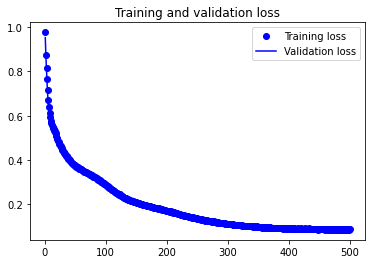

In [19]:
# Plot the training history
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

7/7 [==============================] - 0s 1ms/step


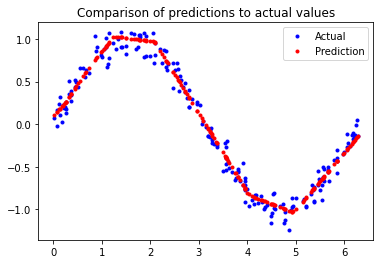

In [20]:
# Plot predictions against actual values
predictions = model.predict(x_test)

plt.clf()
plt.title("Comparison of predictions to actual values")
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_test, predictions, 'r.', label='Prediction')
plt.legend()
plt.show()

In [21]:
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

3196

In [22]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str
     

In [23]:
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))